In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [279]:
# pip uninstall scikit-learn

In [280]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, average_precision_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.preprocessing import StandardScaler,OneHotEncoder,TargetEncoder 
# from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import resample

In [281]:
# pip install category_encoders

In [282]:
df_accident = pd.read_csv(f"E:\Data Science Study\ML Project\Data\Road_Accident_Data\Final_Meet.csv")

In [283]:
df_accident.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100927 entries, 0 to 100926
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Accident_Index              100927 non-null  object 
 1   Accident Date               100927 non-null  object 
 2   Day_of_Week                 100927 non-null  object 
 3   Junction_Control            100927 non-null  object 
 4   Junction_Detail             100927 non-null  object 
 5   Accident_Severity           100927 non-null  object 
 6   Latitude                    100927 non-null  float64
 7   Light_Conditions            100927 non-null  object 
 8   Local_Authority_(District)  100927 non-null  int64  
 9   Carriageway_Hazards         62477 non-null   object 
 10  Longitude                   100927 non-null  float64
 11  Number_of_Casualties        100927 non-null  int64  
 12  Number_of_Vehicles          100927 non-null  int64  
 13  Police_Force  

In [284]:
df_accident.isnull().sum()

Accident_Index                    0
Accident Date                     0
Day_of_Week                       0
Junction_Control                  0
Junction_Detail                   0
Accident_Severity                 0
Latitude                          0
Light_Conditions                  0
Local_Authority_(District)        0
Carriageway_Hazards           38450
Longitude                         0
Number_of_Casualties              0
Number_of_Vehicles                0
Police_Force                      0
Road_Surface_Conditions           0
Road_Type                         0
Speed_limit                       0
Time                              0
Urban_or_Rural_Area               0
Weather_Conditions                0
dtype: int64

##### Code Added By Harsh Patel
##### 1.Handled nan value in Carriageway_Hazards
##### 2.Handled Duplicates in Dataset

In [285]:
# Added by Harsh Patel

# df_accident.drop(columns=['Accident_Index', 'Accident Date', 'Latitude', 'Longitude', 'Time'], axis=1, inplace=True)

In [286]:
# Added by Harsh Patel

df_accident.describe()

,Latitude,Local_Authority_(District),Longitude,Number_of_Casualties,Number_of_Vehicles,Speed_limit
count,100927.000000,100927.0,100927.000000,100927.000000,100927.000000,100927.000000
mean,52.383155,-1.0,-1.229156,1.270938,1.818285,35.879666
std,1.319833,0.0,1.356707,0.695701,0.691123,14.536307
min,49.912210,-1.0,-7.388680,1.000000,1.000000,-1.000000
25%,51.464760,-1.0,-2.124290,1.000000,1.000000,30.000000
50%,51.889930,-1.0,-1.141100,1.000000,2.000000,30.000000
75%,53.347150,-1.0,-0.139255,1.000000,2.000000,40.000000
max,60.344800,-1.0,1.756220,21.000000,26.000000,70.000000


In [287]:
# Added by Harsh Patel

df_accident.columns

Index(['Accident_Index', 'Accident Date', 'Day_of_Week', 'Junction_Control',
       'Junction_Detail', 'Accident_Severity', 'Latitude', 'Light_Conditions',
       'Local_Authority_(District)', 'Carriageway_Hazards', 'Longitude',
       'Number_of_Casualties', 'Number_of_Vehicles', 'Police_Force',
       'Road_Surface_Conditions', 'Road_Type', 'Speed_limit', 'Time',
       'Urban_or_Rural_Area', 'Weather_Conditions'],
      dtype='object')

In [288]:
# Added by Harsh Patel

df_accident['Carriageway_Hazards'] = df_accident['Carriageway_Hazards'].replace(np.nan, 'None')

In [289]:
df_accident.isnull().sum()

Accident_Index                0
Accident Date                 0
Day_of_Week                   0
Junction_Control              0
Junction_Detail               0
Accident_Severity             0
Latitude                      0
Light_Conditions              0
Local_Authority_(District)    0
Carriageway_Hazards           0
Longitude                     0
Number_of_Casualties          0
Number_of_Vehicles            0
Police_Force                  0
Road_Surface_Conditions       0
Road_Type                     0
Speed_limit                   0
Time                          0
Urban_or_Rural_Area           0
Weather_Conditions            0
dtype: int64

In [290]:
df_accident.dropna(inplace=True)

In [291]:
# Added by Harsh Patel

df_accident.duplicated().sum()

np.int64(0)

In [292]:
# Added by Harsh Patel

df_accident.drop_duplicates(inplace=True)

##### Created by Meet Gandhi | Method created to alter the columns value that were necessary and apply custom sampling to the data.

##### Modified by Harsh Patel
##### 1. Added 'Other' Category by Combining Rare values
##### 2. Handled Rare values in  'Local_Authority ' by Creating 'District_Cleaned' and Mapped it by Naming 'District_Freq'
##### 3. Handled 'Police_Force' by extracting top 15 police force and handling rare values by combining and named it as 'other' mapped it by naming 'Police_Force_Encoded'

In [293]:
def alter_columns(X):
    X = X.copy()
    
    drop_columns = ['Latitude','Longitude','Accident_Index','Time','Local_Authority_(District)','Accident Date']
    X.drop(columns=drop_columns,inplace=True)
    
    X['Junction_Control'] = X['Junction_Control'].replace('Auto traffic sigl','Auto traffic signal')
#   df_accident = df_accident[df_accident['Junction_Control']!='Data missing or out of range']
    
    # Changes Done by Harsh Patel

    rare = X['Junction_Control'].value_counts()[X['Junction_Control'].value_counts() < 500].index
    X['Junction_Control'] = X['Junction_Control'].replace(rare, 'Other')

    # Changes Done by Harsh Patel Ends Here

    X['Accident_Severity'] = X['Accident_Severity'].replace('Fetal','Fatal')
    X['Accident_Severity'] = X['Accident_Severity'].replace('Fatal','Serious/Fatal')
    X['Accident_Severity'] = X['Accident_Severity'].replace('Serious','Serious/Fatal')
    
    # # Changes Done by Harsh Patel
    # threshold = 0.005  # 0.5% of data
    # value_counts = X['Local_Authority_(District)'].value_counts(normalize=True)
    # rare_districts = value_counts[value_counts < threshold].index

    # X['District_Cleaned'] = X['Local_Authority_(District)'].replace(rare_districts, 'Other')

    # # Step 2: Frequency encode
    # freq_map = X['District_Cleaned'].value_counts(normalize=True)
    # X['District_Freq'] = X['District_Cleaned'].map(freq_map)

    # # Keep top 15 forces
    # top_forces = X['Police_Force'].value_counts().nlargest(15).index

    # # Group rare ones as 'Other'
    # X['Police_Force_Grouped'] = X['Police_Force'].apply(
    #     lambda x: x if x in top_forces else 'Other'
    # )

    # # Frequency encode
    # force_freq = X['Police_Force_Grouped'].value_counts(normalize=True)
    # X['Police_Force_Encoded'] = X['Police_Force_Grouped'].map(force_freq)

    # # Changes Done by Harsh Patel Ends Here

    X['Road_Surface_Conditions'] = X['Road_Surface_Conditions'].replace('Wet or damp','Wet')
    X['Road_Surface_Conditions'] = X['Road_Surface_Conditions'].replace('Frost or ice','Frost')
    X['Road_Surface_Conditions'] = X['Road_Surface_Conditions'].replace('Flood over 3cm. deep','Flood')
    
#   X.drop(columns = ['Police_Force'],inplace=True)
    
    X['Accident_Severity'] = X['Accident_Severity'].map({
        'Slight': 0,
        'Serious/Fatal' : 1
    })
      
    return X

In [294]:
def val_counts(X,column_name):
    print(X[column_name].value_counts())

val_counts(df_accident,'Accident_Severity')

Accident_Severity
Slight     75858
Serious    23567
Fatal       1502
Name: count, dtype: int64


##### Created by Meet Gandhi | Class creation for the Feature Engineering that need to be done for the X_test and y_train.

##### Modified By Harsh Patel
##### 1. Created 'Weather_Risk_Score'
##### 2. Created 'Vehicle_Category' by Mapping 'Vehicle_Type'
##### 3. Created 'Casualties_per_Vehicle'
##### 4. Created 'High_Speed_Zone'
##### 5. Created 'Is_Weekend', 'Is_Roundabout', 'Is_Single_Carriageway'
##### 6. Created 'Lighting_Quality_Score', 'Speed_Weather_Interaction'
##### 7. Created 'Dark_Rural_Risk'

In [ ]:

class Feature_Engineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X = X.copy()

        # X.drop(columns=drop_columns,inplace=True)

        # Creating new column from Urban_or_Rural Columns from the data.
        X['is_urban'] = X['Urban_or_Rural_Area'] == 'Urban'
        # X.drop(columns=['Urban_or_Rural_Area'],inplace=True)
        
        # Creating new column from CarrieHazards from the data.
        X['is_Carry_hazards'] = X['Carriageway_Hazards'] != 'None'
        X.drop(columns=['Carriageway_Hazards'],inplace=True)
        
        # Changes Done By Harsh Pate;

        weather_map = {
            'Fine no high winds': 0,
            'Fine + high winds': 1,
            'Raining no high winds': 2,
            'Raining + high winds': 3,
            'Snowing no high winds': 4,
            'Snowing + high winds': 5,
            'Fog or mist': 6,
            'Other': 7
        }
        X['Weather_Risk_Score'] = X['Weather_Conditions'].map(weather_map)

        # Changes Done By Harsh Patel Ends Here

        # Creating new columns from the weather_conditions.
        X['Weather_Condition'] = X['Weather_Conditions'].str.replace(r'\s*\+\s*high winds','',regex=True)
        X['Weather_Condition'] = X['Weather_Conditions'].str.replace(r'\s*no high winds','',regex=True)
        
        X['Wind_Condition'] = X['Weather_Conditions'].apply(
        lambda x: 'No High Winds' if 'no high winds' in x.lower()
            else ('High Winds' if 'high winds' in x.lower() else 'Other')
        )
        
        X.drop(columns = ['Weather_Conditions'],inplace=True)

        # Changes Done By Harsh Patel

        # X['Vehicle_Category'] = X['Vehicle_Type'].apply(
        #     lambda x: 'Four_Wheeler' if x in ['Car', 'Taxi/Private hire car', 'Van / Goods 3.5 tonnes mgw or under']
        #     else ('Motorcycle' if x is 'Motorcycle'
        #     else ('Heavy_Vehicle' if x in ['Goods 7.5 tonnes mgw and over', 'Goods over 3.5t. and under 7.5t', 
        #        'Bus or coach (17 or more pass seats)', 'Minibus (8 - 16 passenger seats)']
        #     else 'Other'))
        # )

        # # Vehicle grouping
        # def vehicle_category(v):
        #     if 'Motorcycle' in v: return 'Two_Wheeler'
        #     elif 'Car' in v or 'Taxi' in v: return 'Four_Wheeler'
        #     elif 'Goods' in v: return 'Heavy_Vehicle'
        #     elif 'Bus' in v or 'Minibus' in v: return 'Public'
        #     else: return 'Other'

        # X['Vehicle_Category'] = X['Vehicle_Type'].apply(vehicle_category)

        # X.drop(columns = ['Vehicle_Type'],inplace=True)

        X['Casualties_per_Vehicle'] = X['Number_of_Casualties'] / X['Number_of_Vehicles']
        X['Casualties_per_Vehicle'].replace([np.inf, -np.inf], np.nan, inplace=True)
        X['Casualties_per_Vehicle'].fillna(X['Casualties_per_Vehicle'].median(), inplace=True)

        X['High_Speed_Zone'] = np.where(X['Speed_limit'] > 50, 'Speed_Zone', 'Normal_Zone')

        X['Vehicle_Count_Bin'] = pd.cut(X['Number_of_Vehicles'], 
                                 bins=[0,1,3,6,100], 
                                 labels=['Single','Few','Several','Many'])

        # X.drop(['Number_of_Casualties', 'Casualties_per_Vehicle'], axis=1, inplace=True)
        
        X['Is_Weekend'] = X['Day_of_Week'].isin(['Saturday','Sunday']).astype(int)

        X['Is_Roundabout'] = (X['Road_Type'] == 'Roundabout').astype(int)
        X['Is_Single_Carriageway'] = (X['Road_Type'] == 'Single carriageway').astype(int)
        # X['Urban_or_Rural_Area'] = X['Urban_or_Rural_Area'].map({'Urban':0, 'Rural':1})

        lighting_map = {
            'Daylight': 0,
            'Darkness - lights lit': 1,
            'Darkness - lights unlit': 2,
            'Darkness - no lighting': 3,
            'Darkness - lighting unknown': 2
        }
        X['Lighting_Quality_Score'] = X['Light_Conditions'].map(lighting_map)

        X['Speed_Weather_Interaction'] = X['Speed_limit'] * X['Weather_Risk_Score']

        # top_districts = X['Local_Authority_(District)'].value_counts().nlargest(10).index
        # X['Local_Authority_(District)'] = X['Local_Authority_(District)'].apply(lambda x: x if x in top_districts else 'Other')

        # top_police = X['Police_Force'].value_counts().nlargest(10).index
        # X['Police_Force'] = X['Police_Force'].apply(lambda x: x if x in top_police else 'Other')


        # def limit_cardinality(col, top_n=20):
        #     top = X[col].value_counts().nlargest(top_n).index
        #     return X[col].where(X[col].isin(top), other='Other')

        # high_card_cols = ['Local_Authority_(District)', 'Police_Force']
        # for c in high_card_cols:
        #     X[c] = limit_cardinality(c, top_n=25)

        # num_impute_cols = ['Weather_Risk_Score', 'Lighting_Quality_Score', 'Casualties_per_Vehicle']
        # for c in num_impute_cols:
        #     if c in X.columns:
        #         X[c + '_was_missing'] = X[c].isna().astype(int)
        #         X[c] = X[c].fillna(X[c].median())

        # Changes Done By Harsh Patel Ends Here

        # Creating new Feature from light_conditions
        X['Light_Condition'] = X['Light_Conditions']
        X['Light_Condition'] = X['Light_Condition'].str.replace(r'Darkness*\s*\-\s*','',regex=True)
        X['Light_Condition'] = X['Light_Condition'].str.replace(r'Daylight','day-light',regex=True)
        
        X['isDarkness'] = X['Light_Conditions'].apply(
            lambda x: False if 'Daylight' in x else True
        )

        # Changes Done by Harsh Patel
        X['Dark_Rural_Risk'] = X['isDarkness'] * X['Urban_or_Rural_Area']
        # Changes Done by Harsh Patel Ends here

        X.drop(columns=['Light_Conditions'],inplace=True)
        
        return X

##### Created by Meet Gandhi | for adding the minority class manually in the data.

In [296]:
df_accident = alter_columns(df_accident)

majority = df_accident[df_accident['Accident_Severity'] == 0]
minority = df_accident[df_accident['Accident_Severity'] != 0]

df_minority_oversampled = resample(
    minority,
    replace=True,        
    n_samples=len(majority[majority['Accident_Severity']==0]),
    random_state=42
)

df_dummy = pd.concat([majority,df_minority_oversampled])
df_dummy['Accident_Severity'].value_counts()

Accident_Severity
0    75858
1    75858
Name: count, dtype: int64

### Categorizing the columns as per their Use in the model.

In [310]:
# Edit

cat_columns = ['Day_of_Week','Junction_Control','Junction_Detail','Road_Surface_Conditions',
               'Road_Type','Weather_Condition','Wind_Condition',
               'Light_Condition']  # Vehicle_Category to be add (Comment by Harsh Patel)
num_columns = ['Casualties_per_Vehicle','Speed_limit', 'Lighting_Quality_Score', 'Speed_Weather_Interaction'] # Weather_Risk_Score, Lighting_Quality_Score, Speed_Weather_Interaction to be added (Comment by Harsh Patel)
bool_columns = ['is_urban', 'is_Carry_hazards', 'High_Speed_Zone', 'Is_Weekend', 'Is_Roundabout', 'Is_Single_Carriageway', 'Dark_Rural_Risk'] #  'isDarkness' to be add i just remove to check score # New Features added by Harsh Patel
target_column = ['Accident_Severity']

###

In [311]:
X = df_dummy.drop(columns = target_column)
y = df_dummy[target_column]

In [312]:
X.columns

Index(['Day_of_Week', 'Junction_Control', 'Junction_Detail',
       'Light_Conditions', 'Carriageway_Hazards', 'Number_of_Casualties',
       'Number_of_Vehicles', 'Police_Force', 'Road_Surface_Conditions',
       'Road_Type', 'Speed_limit', 'Urban_or_Rural_Area',
       'Weather_Conditions'],
      dtype='object')

In [313]:
bool_feature = Pipeline(steps=[
    ('onehot',OneHotEncoder(handle_unknown='ignore',sparse_output=False))
])

col_feature = Pipeline(steps=[
    ('target_encode', TargetEncoder())
])

num_feature = Pipeline(steps=[
    ('scaler',StandardScaler())
])

preprocess = ColumnTransformer(transformers=[
    ('target',col_feature,cat_columns),
    ('bool',bool_feature,bool_columns),
    ('num','passthrough',num_columns)
])

In [314]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.25,random_state=42)

In [315]:
X_train.columns

Index(['Day_of_Week', 'Junction_Control', 'Junction_Detail',
       'Light_Conditions', 'Carriageway_Hazards', 'Number_of_Casualties',
       'Number_of_Vehicles', 'Police_Force', 'Road_Surface_Conditions',
       'Road_Type', 'Speed_limit', 'Urban_or_Rural_Area',
       'Weather_Conditions'],
      dtype='object')

In [316]:
val = len(y['Accident_Severity'].unique())

# XGBoost Implementation

In [317]:
feature_engineer = Feature_Engineering()
pipeline_xgb = Pipeline(steps=[
    ('feature_engineer',feature_engineer),
    ('preprocessor',preprocess),
    ('model', XGBClassifier(objective='binary:logistic',
                           eval_metric='aucpr',
                           tree_method='auto'))
])

grid_params_xgb = {
    'model__n_estimators': [100, 150],
    'model__max_depth': [4, 6, 8],
    'model__learning_rate': [0.05, 0.1, 0.2]
}

In [318]:
gd = GridSearchCV(pipeline_xgb,grid_params_xgb,cv=5,scoring='average_precision',n_jobs=-1,verbose=3)
gd.fit(X_train,y_train)
y_predict_xgb = gd.predict_proba(X_test)[:,1]

Fitting 5 folds for each of 18 candidates, totalling 90 fits


PR-AUC: 0.648465537349465
Average Precision Score: 0.648489686368344


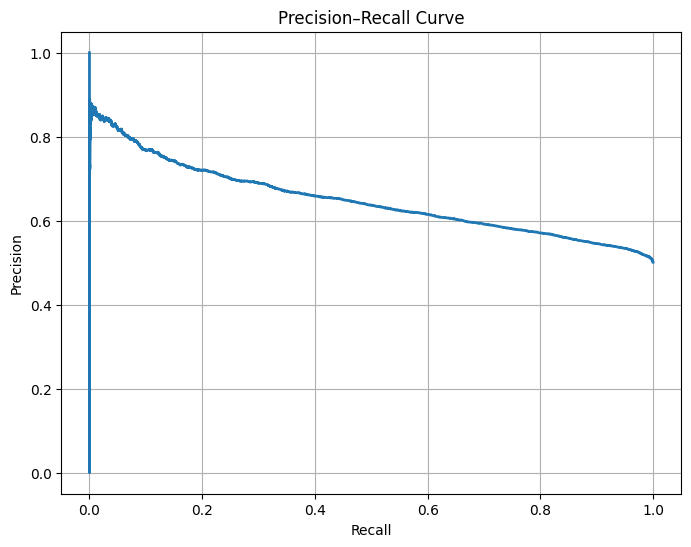

In [319]:
precision_xgb, recall_xgb, thresolds_xgb = precision_recall_curve(y_test,y_predict_xgb)
pr_auc_xgb = auc(recall_xgb,precision_xgb)
avg_precision_xgb = average_precision_score(y_test,y_predict_xgb)

print("PR-AUC:", pr_auc_xgb)
print("Average Precision Score:", avg_precision_xgb)

plt.figure(figsize=(8, 6))
plt.plot(recall_xgb, precision_xgb, linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.grid(True)
plt.show()

In [307]:
print("Best PR-AUC Score:", gd.best_score_)
print("Best Params:", gd.best_params_)

Best PR-AUC Score: 0.6418660289483327
Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 8, 'model__n_estimators': 150}


In [308]:
f1_scores = 2 * (precision_xgb * recall_xgb) / (precision_xgb + recall_xgb)
best_idx = np.argmax(f1_scores)

best_threshold = thresolds_xgb[best_idx]
best_f1 = f1_scores[best_idx]

print("Best Threshold:", best_threshold)
print("Best F1 Score:", best_f1)

Best Threshold: 0.3398155
Best F1 Score: 0.6841828296496767


In [309]:
y_pred_best = (y_predict_xgb >= best_threshold).astype(int)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))


Confusion Matrix:
[[ 2923 15992]
 [  812 18202]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.15      0.26     18915
           1       0.53      0.96      0.68     19014

    accuracy                           0.56     37929
   macro avg       0.66      0.56      0.47     37929
weighted avg       0.66      0.56      0.47     37929

